In [1]:
%reload_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import sys
from collections import Counter
from pathlib import Path
import random
import torch
from matplotlib import pyplot as plt
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from tqdm.notebook import tqdm
from torchvision.models import densenet121
from sklearn.metrics import roc_auc_score
from torch.utils.data.sampler import WeightedRandomSampler

from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [2]:
DATA_PATH = Path('/home/rubn/Desktop/Plant')
IMG_PATH = DATA_PATH / 'images'
LABEL_COLS = ['healthy', 'multiple_diseases', 'rust', 'scab']

IMG_SIZE = 1024
SEED = 420
N_FOLDS = 5
BS = 4 

ARCH = densenet121

In [3]:
seed_everything(SEED)

In [4]:
train_df = pd.read_csv('/home/rubn/Desktop/Plant/train.csv')
test_df = pd.read_csv('/home/rubn/Desktop/Plant/test.csv')

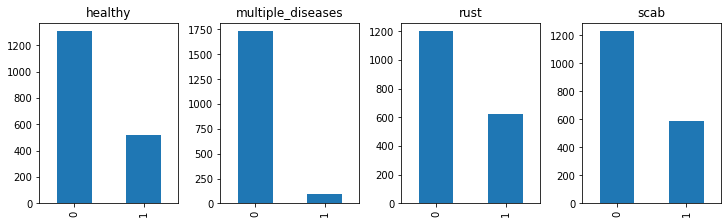

In [5]:
_, axes = plt.subplots(ncols=4, nrows=1, constrained_layout=True, figsize=(10, 3))
for ax, column in zip(axes, LABEL_COLS):
    train_df[column].value_counts().plot.bar(title=column, ax=ax)
plt.show()

In [6]:
## Check multilabels or multiclassification
train_df.iloc[:,1:-1].sum(axis=1).value_counts()
train_df[['healthy', 'multiple_diseases', 'rust', 'scab']].sum(axis=1).unique()

array([1])

In [7]:
## Image size distribution
hs, ws = [], []
for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    img = Image.open(IMG_PATH/(row.image_id+'.jpg'))
    h, w = img.size
    hs.append(h)
    ws.append(w)

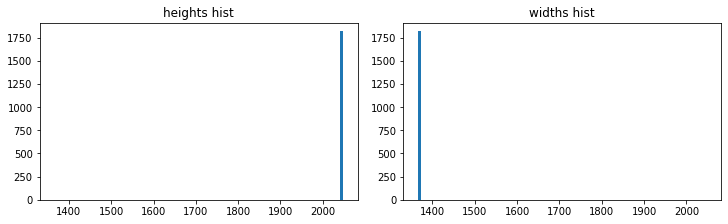

In [8]:
_, axes = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(10, 3))
for ax, column, vals in zip(axes, ['heights', 'widths'], [hs, ws]):
    ax.hist(vals, bins=100)
    ax.set_title(f'{column} hist')

plt.show()

In [9]:
Counter(hs), Counter(ws)

(Counter({2048: 1819, 1365: 2}), Counter({1365: 1819, 2048: 2}))

In [10]:
## Iterative stratification to create balanced fold

In [11]:
train_df['fold'] = -1

strat_kfold = MultilabelStratifiedKFold(n_splits=N_FOLDS, random_state=SEED, shuffle=True)
for i, (_, test_index) in enumerate(strat_kfold.split(train_df.image_id.values, train_df.iloc[:,1:].values)):
    train_df.iloc[test_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

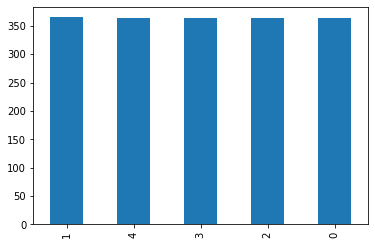

In [12]:
train_df.fold.value_counts().plot.bar()

In [13]:
## Convert to string to one-hot it, I do not know how did fastai2 works with one hot

def get_label(row):
    for k, v in row[LABEL_COLS].items():
        if v == 1:
            return k

train_df['label'] = train_df.apply(get_label, axis=1)

In [14]:
'''
Probably oversampling ???
'''
train_df_no_val = train_df.query('fold != 0')
train_df_just_val = train_df.query('fold == 0')

train_df_bal = pd.concat(
    [train_df_no_val.query('label != "multiple_diseases"'), train_df_just_val] +
    [train_df_no_val.query('label == "multiple_diseases"')] * 2
).sample(frac=1.0, random_state=SEED).reset_index(drop=True)


# train_df_bal.label.value_counts()

In [15]:
datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock(vocab=LABEL_COLS)),
    getters=[
        ColReader('image_id', pref=IMG_PATH, suff='.jpg'),
        ColReader('label')
    ],
    splitter=IndexSplitter(train_df_bal.loc[train_df_bal.fold==0].index),
    item_tfms=Resize(IMG_SIZE),
    batch_tfms=aug_transforms(size=IMG_SIZE, max_rotate=30., min_scale=0.75, flip_vert=True, do_flip=True)
)

In [16]:
dls = datablock.dataloaders(source=train_df_bal,bs=BS)

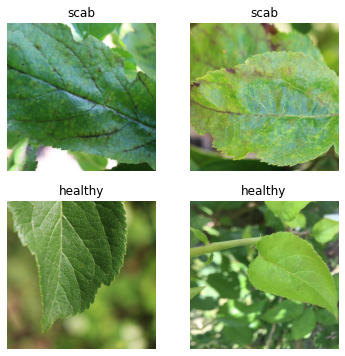

In [17]:
dls.show_batch()

In [18]:
## Training and model

In [19]:
def comp_metric(preds, targs, labels=range(len(LABEL_COLS))):
    # One-hot encode targets
    targs = np.eye(4)[targs]

    return np.mean([roc_auc_score(targs[:,i], preds[:,i]) for i in labels])

def healthy_roc_auc(*args):
    return comp_metric(*args, labels=[0])

def multiple_diseases_roc_auc(*args):
    return comp_metric(*args, labels=[1])

def rust_roc_auc(*args):
    return comp_metric(*args, labels=[2])

def scab_roc_auc(*args):
    return comp_metric(*args, labels=[3])

In [20]:
opt_func = partial(Adam, lr=slice(2e-3), wd=0.01, eps=1e-8)

In [21]:
learn = cnn_learner(
    dls, ARCH, opt_func=opt_func,
    loss_func=LabelSmoothingCrossEntropy(),
    metrics=[
        AccumMetric(healthy_roc_auc, flatten=False, to_np=False, invert_arg=False),
        AccumMetric(multiple_diseases_roc_auc, flatten=False, to_np=False, invert_arg=False),
        AccumMetric(rust_roc_auc, flatten=False, to_np=False, invert_arg=False),
        AccumMetric(scab_roc_auc, flatten=False, to_np=False, invert_arg=False),
        AccumMetric(comp_metric, flatten=False, to_np=False, invert_arg=False)]
).to_fp16()

(3.6307804407442747e-08, 3.019951861915615e-07)

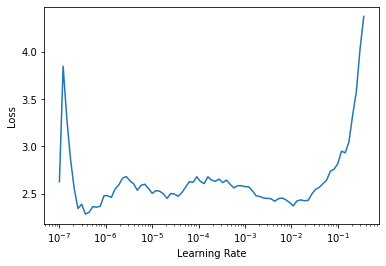

In [22]:
learn.lr_find()

In [23]:
learn.recorder.plot()

AttributeError: 'Learner' object has no attribute 'plot'

In [24]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,healthy_roc_auc,multiple_diseases_roc_auc,rust_roc_auc,scab_roc_auc,comp_metric,time
0,1.558819,1.086115,0.863371,0.790543,0.913623,0.900320,0.866964,03:26
1,1.258656,0.779734,0.932727,0.809249,0.963063,0.891794,0.899208,03:26
2,1.071148,0.686109,0.963806,0.825145,0.980351,0.937388,0.926673,03:26
3,0.951917,0.710728,0.954395,0.824823,0.985774,0.949945,0.928734,03:27


In [25]:
learn.unfreeze()

In [26]:
learn.fit_one_cycle(8, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,healthy_roc_auc,multiple_diseases_roc_auc,rust_roc_auc,scab_roc_auc,comp_metric,time
0,0.953371,0.626443,0.964699,0.880620,0.987431,0.953149,0.946475,04:28
1,0.900764,0.590973,0.975393,0.835822,0.988619,0.961193,0.940257,04:25
2,0.923595,0.559818,0.983521,0.900450,0.988787,0.957989,0.957687,04:25
3,0.853092,0.550631,0.980248,0.900450,0.997858,0.966515,0.961268,04:25
4,0.888069,0.582770,0.968549,0.920360,0.995715,0.964862,0.962371,04:25
5,0.870594,0.526445,0.976305,0.914579,0.995950,0.971889,0.964681,04:25
6,0.854577,0.548989,0.978388,0.921082,0.994377,0.969616,0.965866,04:25
7,0.860652,0.571777,0.974742,0.918272,0.995180,0.966360,0.963639,04:25


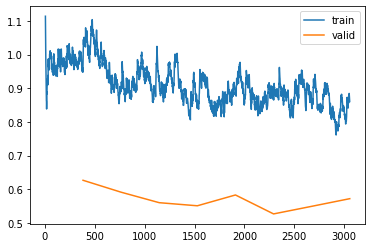

In [27]:
learn.recorder.plot_loss()

In [28]:
interp = ClassificationInterpretation.from_learner(learn)

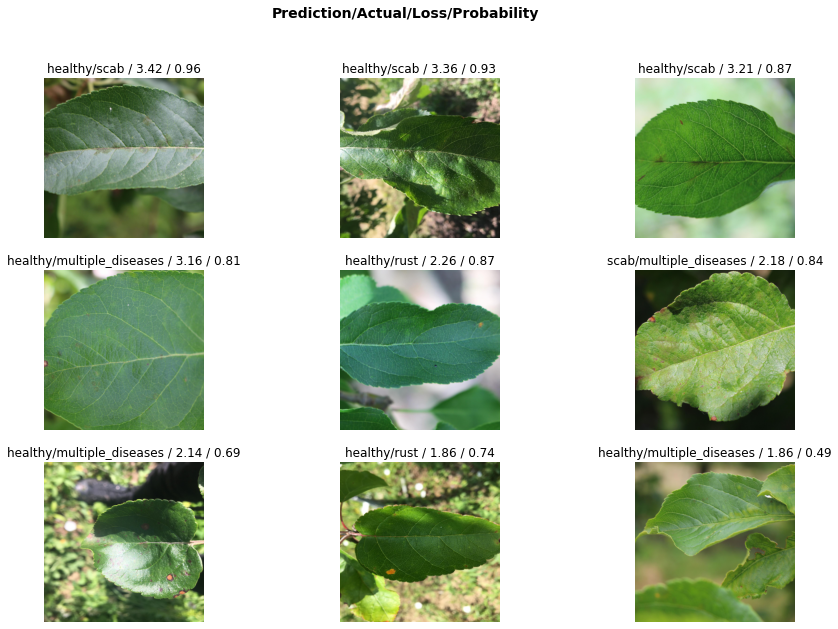

In [29]:
interp.plot_top_losses(9, figsize=(15, 10))

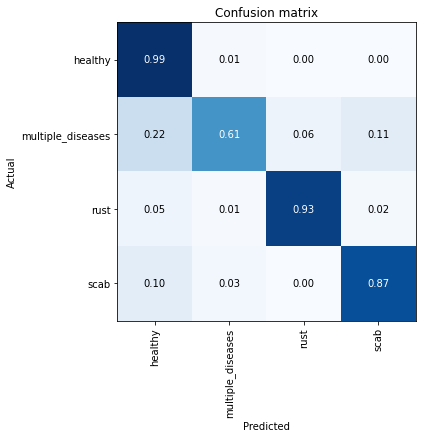

In [30]:
interp.plot_confusion_matrix(normalize=True, figsize=(6, 6))

In [31]:
test_dl = dls.test_dl(test_df)
test_preds, _ = learn.get_preds(dl=test_dl)

In [32]:
test_df_output = pd.concat([test_df, pd.DataFrame(test_preds.numpy(), columns=LABEL_COLS)], axis=1)

In [33]:
test_df_output.to_csv('submission-f.csv', index=False)

In [34]:
learn.save('model1')